<a href="https://colab.research.google.com/github/nadiwashere/dls-course/blob/main/Nadezhda_Kholodova.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Продвинутый поток. Весна 2021</b></h3>

Это домашнее задание будет посвящено полноценному решению задачи машинного обучения.

# Метрика

Перед решением любой задачи важно понимать, как будет оцениваться ваше решение. В данном случае мы используем стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить используя только предсказанные вероятности и истинные классы без конкретного порога классификации + она раотает даже если классы в данных сильно несбалансированны (примеров одного класса в десятки раз больше примеров длугого). Именно поэтому она очень удобна для соревнований.

Посчитать ее легко:


In [ ]:
from sklearn.metrics import roc_auc_score

y_true = [
    0,
    1,
    1,
    0,
    1
]

y_predictions = [
    0.1,
    0.9,
    0.4,
    0.6,
    0.61
]

roc_auc_score(y_true, y_predictions)

0.8333333333333333

# Первая часть. Исследование

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

## Загрузка данных (2 балла)

1) Посмотрите на случайные строчки. 

2) Посмотрите, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna() или data.info() и, если нужно, замените их на что-то. Будет хорошо, если вы построите табличку с количеством nan в каждой колонке.

In [ ]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')


In [ ]:
train.shape, test.shape

((5282, 20), (1761, 19))

Посмотреть на данные можно разными способами. Либо взять случайные строчки, либо только верхние.

In [ ]:
train.sample(5)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
4469,72,104.80,7470.1,Male,0,Yes,No,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Two year,Yes,Bank transfer (automatic),0
570,2,20.35,35.1,Female,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Credit card (automatic),0
2087,69,20.15,1337.5,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),0
1713,4,88.95,355.2,Female,0,No,No,Yes,Yes,Fiber optic,No,Yes,No,No,No,Yes,Month-to-month,Yes,Electronic check,1
676,14,75.35,1025.95,Female,0,No,No,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Electronic check,1


In [ ]:
# Для вашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [ ]:
train.nunique()

ClientPeriod                  73
MonthlySpending             1468
TotalSpent                  4978
Sex                            2
IsSeniorCitizen                2
HasPartner                     2
HasChild                       2
HasPhoneService                2
HasMultiplePhoneNumbers        3
HasInternetService             3
HasOnlineSecurityService       3
HasOnlineBackup                3
HasDeviceProtection            3
HasTechSupportAccess           3
HasOnlineTV                    3
HasMovieSubscription           3
HasContractPhone               3
IsBillingPaperless             2
PaymentMethod                  4
Churn                          2
dtype: int64

In [ ]:
num_features = [*train.nunique()[train.nunique() > 5].index]
cat_features = [*train.nunique()[train.nunique() < 5].index][:-1]
bin_features = [*train.nunique()[train.nunique() == 2].index][:-1]

Посмотрим, есть ли пустые значения. isna не видит пробелы, а isnull видит. 

In [ ]:
train.isna().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

In [ ]:
train.isnull().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

Можно заметить, что есть пробелы, которые мы для удобства заменим на 1 (так выше скор)

In [ ]:
train['TotalSpent'].value_counts(dropna=False).sort_values(ascending=False).head()

         9
20.2     9
19.75    8
20.05    6
19.65    6
Name: TotalSpent, dtype: int64

In [ ]:
train['TotalSpent'] = train['TotalSpent'].replace(r'^\s*$', '1', regex=True).astype('float')

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              1761 non-null   int64  
 1   MonthlySpending           1761 non-null   float64
 2   TotalSpent                1761 non-null   object 
 3   Sex                       1761 non-null   object 
 4   IsSeniorCitizen           1761 non-null   int64  
 5   HasPartner                1761 non-null   object 
 6   HasChild                  1761 non-null   object 
 7   HasPhoneService           1761 non-null   object 
 8   HasMultiplePhoneNumbers   1761 non-null   object 
 9   HasInternetService        1761 non-null   object 
 10  HasOnlineSecurityService  1761 non-null   object 
 11  HasOnlineBackup           1761 non-null   object 
 12  HasDeviceProtection       1761 non-null   object 
 13  HasTechSupportAccess      1761 non-null   object 
 14  HasOnlin

In [ ]:
test['TotalSpent'] = test['TotalSpent'].replace(r'^\s*$', '1', regex=True).astype('float')

## Анализ данных (3 балла)

1) Для численных призанков постройте гистограмму (*plt.hist(...)*) или boxplot (*plt.boxplot(...)*). Для категориальных посчитайте количество каждого значения для каждого признака. Для каждой колонки надо сделать *data.value_counts()* и построить bar диаграммы *plt.bar(...)* или круговые диаграммы *plt.pie(...)* (хорошо, елси вы сможете это сделать на одном гарфике с помощью *plt.subplots(...)*). 

2) Посмотрите на распределение целевой переменной и скажите, являются ли классы несбалансированными.

3) (Если будет желание) Поиграйте с разными библиотеками для визуализации - *sns*, *pandas_visual_analysis*, etc.

Второй пункт очень важен, потому что существуют задачи классификации с несбалансированными классами. Например, это может значить, что в датасете намного больше примеров 0 класса. В таких случаях нужно 1) не использовать accuracy как метрику 2) использовать методы борьбы с imbalanced dataset (обычно если датасет сильно несбалансирован, т.е. класса 1 в 20 раз меньше класса 0).

In [ ]:
test.describe()

,ClientPeriod,MonthlySpending,TotalSpent,IsSeniorCitizen
count,1761.000000,1761.000000,1761.00000,1761.000000
mean,32.293583,64.272601,2256.48427,0.170358
std,24.593736,29.832517,2260.50066,0.376054
min,0.000000,18.550000,1.00000,0.000000
25%,9.000000,35.650000,405.60000,0.000000
50%,29.000000,70.050000,1356.30000,0.000000
75%,56.000000,89.400000,3759.05000,0.000000
max,72.000000,117.350000,8496.70000,1.000000


Судя по таблице выше, полноценной непрерывностью отличаются лишь признаки ClientPeriod и MonthlySpending.
IsSeniorCitizen и Churn же являются бинарными

In [ ]:
def corrmat(data):
    plt.figure(figsize=(10,10))
    sns.heatmap(data.corr(), cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}).set_title("Correlation Matrix")
    plt.show()

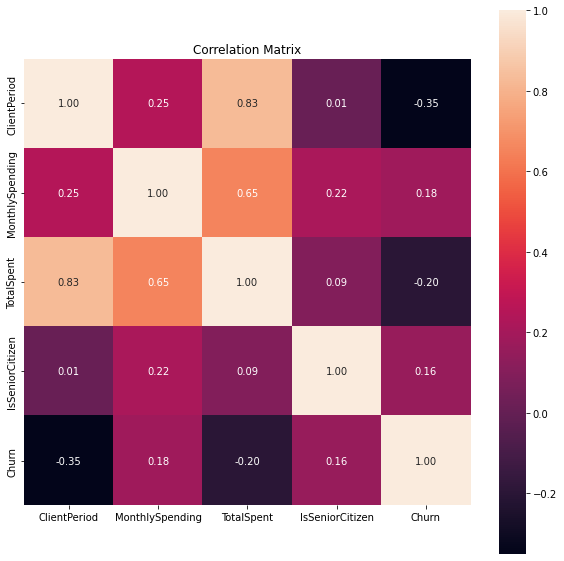

In [ ]:
corrmat(train)

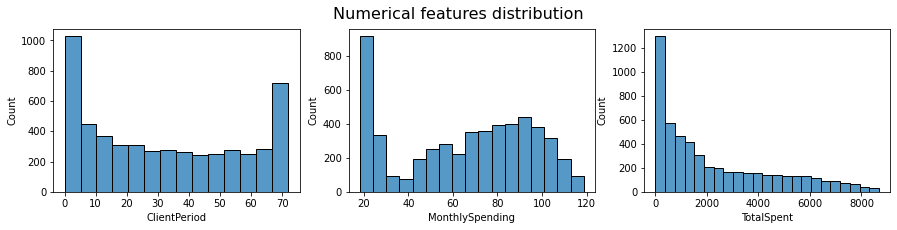

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
fig.suptitle("Numerical features distribution", fontsize=(16))
for index, axis in enumerate(axes):
    sns.histplot(data=train[num_features[index]], ax=axis)

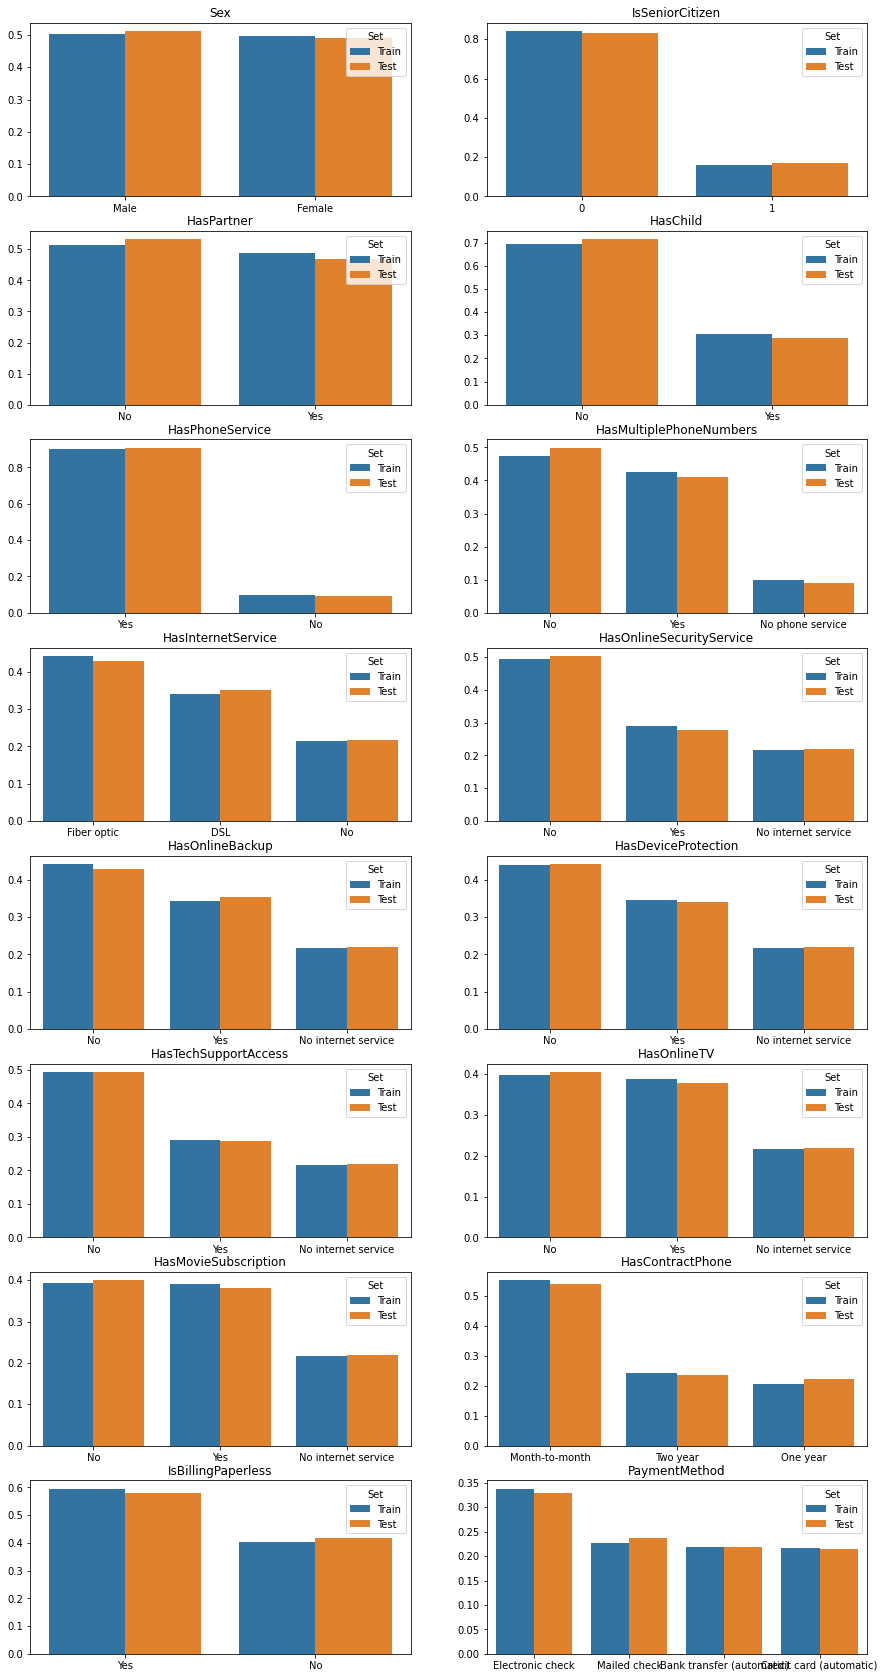

In [ ]:
_, axes = plt.subplots(len(cat_features) // 2, 2, figsize=(15, 30))

for i in range(len(cat_features)):
    
    j = i // 2
    k = i % 2
    axis = axes[j][k]
    feature = cat_features[i]
    
    cat_train_data = train[feature].value_counts() / len(train)
    cat_train_data = pd.DataFrame(cat_train_data)
    cat_train_data['Set'] = 'Train'
    cat_test_data = test[feature].value_counts() / len(test)
    cat_test_data = pd.DataFrame(cat_test_data)
    cat_test_data['Set'] = 'Test'
    cat_data = pd.concat([cat_train_data, cat_test_data])
    
    sns.barplot(data=cat_data, ax=axis, x=cat_data.index, y=feature, hue='Set')
    axis.set(title=feature, ylabel=None)

С распределением числовых и категориальных фичей вроде все нормально. Теперь изучим целевую переменную

Виден дисбаланс классов:


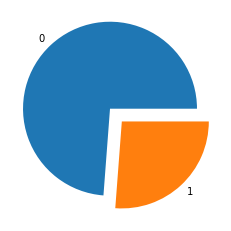

In [ ]:
plt.pie(train[target_col].value_counts(), labels=[0, 1], explode=[0.1, 0.1])
print('Виден дисбаланс классов:');

## Применение линейных моделей (3 балла)

1) Обработайте данные для того, чтобы к ним можно было применить LogisticRegression. Т.е. отнормируйте числовые признаки, а категориальные закодируйте с помощью one-hot-encoding'а. 

2) С помощью кроссвалидации или разделения на train/valid выборку протестируйте разные значения гиперпараметра C и выберите лучший (можно тестировать С=100, 10, 1, 0.1, 0.01, 0.001) по метрике ROC-AUC. 

Если вы разделяете на train/valid, то используйте LogisticRegressionCV. Он сам при вызове .fit() подберет параметр С. (не забудьте передать scroing='roc_auc', чтобы при кроссвалидации сравнивались значения этой метрики, и refit=True, чтобы при потом модель обучилась на всем датасете с лучшим параметром C). 


(более сложный вариант) Если вы будете использовать кроссвалидацию, то преобразования данных и LogisticRegression нужно соединить в один Pipeline с помощью make_pipeline, как это делалось во втором семинаре. Потом pipeline надо передать в GridSearchCV. Для one-hot-encoding'a можно испльзовать комбинацию LabelEncoder + OneHotEncoder (сначала превращаем строчки в числа, а потом числа првращаем в one-hot вектора.)

In [ ]:
from sklearn.metrics import roc_auc_score, make_scorer, roc_curve, auc
from sklearn.preprocessing import StandardScaler, RobustScaler, OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

In [ ]:
X = train.iloc[:, :-1]
y = train.iloc[:, -1]

In [ ]:
cols = list(set(cat_features) - set(bin_features))
df = pd.concat([pd.get_dummies(train.iloc[:, :-1], columns=cols), train.iloc[:, -1]], axis=1).sample(frac=1)
df['Sex'] = (df['Sex'] == 'Male').astype(int)
df[bin_features[2:]] = (df[bin_features[2:]] == 'Yes').astype(int)

X_train, X_val, y_train, y_val = train_test_split(df.iloc[:, :-1], df.iloc[:, -1], test_size=0.2)

scaler = StandardScaler()
X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_val[num_features] = scaler.transform(X_val[num_features])

In [ ]:
param_grid = {'C': [10 ** i for i in range(-3, 3)], 'max_iter': [1000]}

search = GridSearchCV(LogisticRegression(), param_grid, scoring=make_scorer(roc_auc_score), cv=5)
search.fit(X_train, y_train)

params = search.best_params_
print(f'The best params: {params}')

The best params: {'C': 1, 'max_iter': 1000}


In [ ]:
linear_model = LogisticRegression()
linear_model.set_params(**params)
linear_model.fit(X_train, y_train)
y_pred = linear_model.predict_proba(X_val)[:, 1]
print(f'Validation ROC-AUC: {roc_auc_score(y_val, y_pred)}')

Validation ROC-AUC: 0.840479496436175


0.84 with c=1

## Применение градиентного бустинга (2 балла)

Если вы хотите получить баллы за точный ответ, то стоит попробовать градиентный бустинг. Часто градиентный бустинг с дефолтными параметрами даст вам 80% результата за 0% усилий.

Мы будем использовать catboost, поэтому нам не надо кодировать категориальные признаки. catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А численные признаки нормировать для моделей, основанных на деревьях не нужно.

1) Разделите выборку на train/valid. Протестируйте catboost cо стандартными параметрами.

2) Протестируйте разные занчения параметроа количества деревьев и learning_rate'а и выберите лучшую по метрике ROC-AUC комбинацию. 

(Дополнительно) Есть некоторые сложности с тем, чтобы использовать CatBoostClassifier вместе с GridSearchCV, поэтому мы не просим использовать кроссвалидацию. Но можете попробовать)

In [ ]:
!pip install catboost

простой катбуст

In [ ]:
from catboost import CatBoostClassifier, Pool

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [ ]:
catboost_default = CatBoostClassifier(cat_features=cat_features)
catboost_default.fit(X_train, y_train, verbose=False)
y_predict = catboost_default.predict_proba(X_valid)[:, 1]

In [ ]:
y_train_predicted = catboost_default.predict_proba(X_train)[:, 1]
y_test_predicted = y_predict

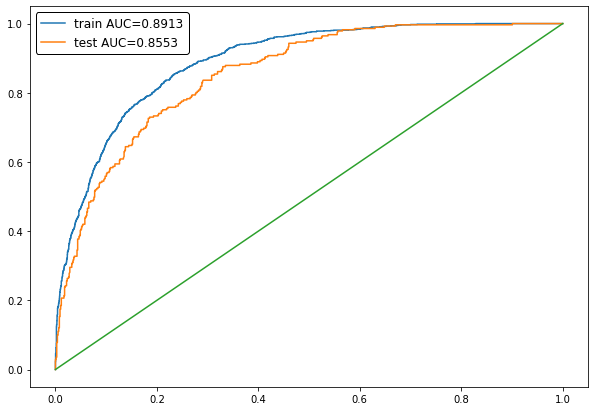

In [ ]:
train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_valid, y_test_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_valid, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

In [ ]:
roc_auc_score(y_valid, y_predict)

0.8552894669259272

Хороший результат, но попробуем его улучшить, подобрав параметры.

In [ ]:
param_grid = {'depth': [2, 3, 4],
              'learning_rate': [0.02, 0.03, 0.04]}

In [ ]:
train_dataset = Pool(X_train, y_train, cat_features)
val_dataset = Pool(X_valid, y_valid, cat_features)

In [ ]:
model = CatBoostClassifier(eval_metric='AUC:hints=skip_train~false', early_stopping_rounds=100)
search = model.grid_search(param_grid, train_dataset, cv=5, verbose=False)
print(search['params'])

{'depth': 2, 'learning_rate': 0.03}


In [ ]:
print(f'Validation ROC-AUC: {roc_auc_score(y_valid, model.predict_proba(val_dataset)[:, 1])}')

Validation ROC-AUC: 0.8571123931467145


# Предсказания

In [ ]:
best_model = CatBoostClassifier(cat_features=cat_features, depth=2, learning_rate=0.03)
best_model.fit(X_train, y_train, verbose=False)
X_test = pd.read_csv('./test.csv')
submission = pd.read_csv('./submission.csv')

In [ ]:
X_test.TotalSpent = np.where(X_test.TotalSpent == ' ', '1', X_test.TotalSpent).astype(float)
X_test.TotalSpent.fillna(X_test.TotalSpent.mean(), inplace=True)
submission['Churn'] = best_model.predict_proba(X_test)[:, 1]
submission.to_csv('./my_submission1.csv', index=False)

In [ ]:
submission.head(5)

,Id,Churn
0,0,0.055382
1,1,0.724364
2,2,0.720823
3,3,0.014327
4,4,0.004855


Nadezhda_Kholodova, 0.85195
https://www.kaggle.com/nadezhdakholodova

# Kaggle (5 баллов)

Как выставить баллы:

1) 1 >= roc auc > 0.84 это 5 баллов

2) 0.84 >= roc auc > 0.7 это 3 балла

3) 0.7 >= roc auc > 0.6 это 1 балл

4) 0.6 >= roc auc это 0 баллов
